In [1]:
import sys
import numpy as np
import pandas as pd
import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from scipy import stats
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## Model

In [149]:
# def garch_model(train, test, date_index, cut_date, num_of_predictions):
#     train = pd.DataFrame(train, index = date_index[date_index < cut_date]).dropna()
#     test = pd.DataFrame(test, index = date_index[date_index >= cut_date].dropna())
#     data = pd.concat([train, test], axis=0).astype('float64')
#     print(data)
#     basic_gm = arch_model(data.values, p=1, q=1, mean='Constant', #mean: 'AR', 'ARX', 'Constant', 'Zero', 'LS', 'HAR', 'HARX' 
#                           vol = 'ARCH', dist = 'normal') #'vol: 'Garch', 'ARCH', 'HARCH' #dist: 'normal','skewt','t'
#     start_loc = 0
#     end_loc = np.where(data.index >= test.index[0])[0].min()
#     forecasts = {} 
#     for i in range(1,num_of_predictions+1):
#         sys.stdout.write('.')
#         sys.stdout.flush()
#         res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
#         temp = res.forecast(horizon=1).variance#mean or variance (residual variance)
        
#         fcast = temp.iloc[i + end_loc - 1]
#         forecasts[fcast.name] = fcast
#     forecasts_df = pd.DataFrame(forecasts).T
#     return forecasts_df


In [419]:
def garch_model(train, test, combo, data, num_of_predictions):
    basic_gm = arch_model(data.values, p=combo[0], q=combo[1], mean='constant', #mean: 'AR', 'ARX', 'Constant', 'Zero', 'LS', 'HAR', 'HARX' 
                          vol = combo[2], dist = 'normal') #'vol: 'Garch', 'ARCH', 'HARCH' #dist: 'normal','skewt','t'
    start_loc = 0
    end_loc = np.where(data.index >= test.index[0])[0].min()
    forecasts = {} 
    for i in range(1,num_of_predictions+1):
        sys.stdout.write('.')
        sys.stdout.flush()
        res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
        temp = res.forecast(horizon=1).variance #mean or variance (residual variance)        
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast
    forecasts_df = pd.DataFrame(forecasts).T
    return forecasts_df

## Evaluation

In [209]:
def evaluation_metrics(test_data, predictions):
    metrics = {}
    
    metrics['MAPE'] = mean_absolute_percentage_error(predictions,test_data)
    metrics['MSE'] = mean_squared_error(test_data,predictions)
    
    return metrics

## Pipeline

In [3]:
cap_list = ['nano','micro','small','medium','large','mega']

In [416]:
import itertools
p = [1,2,3]
q = [1,2,3]
vol = ['ARCH','GARCH']
params = [p,q,vol]
params = list(itertools.product(*params))
params

[(1, 1, 'ARCH'),
 (1, 1, 'GARCH'),
 (1, 2, 'ARCH'),
 (1, 2, 'GARCH'),
 (1, 3, 'ARCH'),
 (1, 3, 'GARCH'),
 (2, 1, 'ARCH'),
 (2, 1, 'GARCH'),
 (2, 2, 'ARCH'),
 (2, 2, 'GARCH'),
 (2, 3, 'ARCH'),
 (2, 3, 'GARCH'),
 (3, 1, 'ARCH'),
 (3, 1, 'GARCH'),
 (3, 2, 'ARCH'),
 (3, 2, 'GARCH'),
 (3, 3, 'ARCH'),
 (3, 3, 'GARCH')]

In [436]:
#Tuning
metrics_df_tune = pd.DataFrame()
cut_date = '2021-01-01'

for combo in params:
    for cap_size in cap_list:
        result_metric_dict = {}

        a_file = open('processed_data/' + cap_size + '_train.pkl', "rb")
        train_data = pickle.load(a_file)

        a_file = open('processed_data/' + cap_size + '_test.pkl', "rb")
        test_data = pickle.load(a_file)


        for stock_ticker in train_data.keys():
            #print(stock_ticker)
            train = pd.DataFrame(train_data[stock_ticker],columns=['date','return']).set_index(['date'])
            test = pd.DataFrame(test_data[stock_ticker],columns=['date','return']).set_index(['date'])
            data = pd.concat([train,test], axis=0).astype('float64')

            prediction = garch_model(train, test, combo, data, len(test))
            result_metric_dict[stock_ticker] = evaluation_metrics(test['return'],prediction['h.1'])

        metrics_df = pd.DataFrame(result_metric_dict).T
        metrics_df['Cap_size'] = cap_size
        metrics_df['params'] = str(combo)

        metrics_df_tune = metrics_df_tune.append(metrics_df)

In [435]:
metrics_df_tune.groupby(by=['Cap_size','params']).describe()['MAPE']

count       mean        std        min        25%  \
Cap_size params                                                               
large    (1, 1, 'ARCH')    79.0  23.236964   6.596368   9.937918  18.016965   
         (1, 1, 'GARCH')   79.0  30.384715   9.758757  10.767987  23.014008   
         (1, 2, 'ARCH')    79.0  23.236964   6.596368   9.937918  18.016965   
         (1, 2, 'GARCH')   79.0  30.230372  10.072024  10.093834  22.636759   
         (1, 3, 'ARCH')    79.0  23.236964   6.596368   9.937918  18.016965   
...                         ...        ...        ...        ...        ...   
small    (3, 1, 'GARCH')   92.0  23.959483  12.271278   3.339364  15.612231   
         (3, 2, 'ARCH')    92.0  20.970014   9.745771   2.736556  14.098252   
         (3, 2, 'GARCH')   92.0  23.809874  11.972570   3.339367  15.055711   
         (3, 3, 'ARCH')    92.0  20.970014   9.745771   2.736556  14.098252   
         (3, 3, 'GARCH')   92.0  23.689163  11.857348   3.315811  15.455506   

                                50%        75%        max  
Cap_size params                                            
large    (1, 1, 'ARCH')   22.827077  27.957977  39.023115  
         (1, 1, 'GARCH')  29.888048  37.955744  58.980052  
         (1, 2, 'ARCH')   22.827077  27.957977  39.023115  
         (1, 2, 'GARCH')  29.148743  38.040699  60.291958  
         (1, 3, 'ARCH')   22.827077  27.957977  39.023115  
...                             ...        ...        ...  
small    (3, 1, 'GARCH')  21.564284  28.947315  77.330531  
         (3, 2, 'ARCH')   19.879397  26.967761  56.563264  
         (3, 2, 'GARCH')  21.603060  30.027270  75.615974  
         (3, 3, 'ARCH')   19.879397  26.967761  56.563264  
         (3, 3, 'GARCH')  21.211789  29.877443  74.474197  

[108 rows x 8 columns]

In [210]:
metrics_df_concat = pd.DataFrame()
cut_date = '2021-01-01'

for cap_size in cap_list:
    result_metric_dict = {}
    
    a_file = open('processed_data/' + cap_size + '_train.pkl', "rb")
    train_data = pickle.load(a_file)
    
    a_file = open('processed_data/' + cap_size + '_test.pkl', "rb")
    test_data = pickle.load(a_file)
    
    
    for stock_ticker in train_data.keys():
        print(stock_ticker)
        train = pd.DataFrame(train_data[stock_ticker],columns=['date','return']).set_index(['date'])
        test = pd.DataFrame(test_data[stock_ticker],columns=['date','return']).set_index(['date'])
        data = pd.concat([train,test], axis=0).astype('float64')
        
        prediction = garch_model(train, test, data, len(test))
        result_metric_dict[stock_ticker] = evaluation_metrics(test['return'],prediction['h.1'])

    metrics_df = pd.DataFrame(result_metric_dict).T
    metrics_df['Cap_size'] = cap_size
    
    metrics_df_concat = metrics_df_concat.append(metrics_df)

WVVIP
.............................................................................................................................................................................................................................................CBIO
.............................................................................................................................................................................................................................................CYCCP
.............................................................................................................................................................................................................................................CLRB
.............................................................................................................................................................................................................................................NSYS
.........................

/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


........................

/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....................................LIXT
.............................................................................................................................................................................................................................................IDRA
.............................................................................................................................................................................................................................................REED
.............................................................................................................................................................................................................................................ZIVO
........................................................................................................................................................................................................................................

.............................................................................................................................................................................................................................................TANNI
.............................................................................................................................................................................................................................................BPOPM
.............................................................................................................................................................................................................................................EKSO
.............................................................................................................................................................................................................................................XBIO
..............................

.............................................................................................................................................................................................................................................BYFC
.............................................................................................................................................................................................................................................AESE
.............................................................................................................................................................................................................................................HSON
.............................................................................................................................................................................................................................................VIRC
................................

.............................................................................................................................................................................................................................................UONE
.............................................................................................................................................................................................................................................MINM
.............................................................................................................................................................................................................................................WVVI
.............................................................................................................................................................................................................................................MLVF
................................

.............................................................................................................................................................................................................................................GTIM
.............................................................................................................................................................................................................................................NWPX
.............................................................................................................................................................................................................................................TXMD
.............................................................................................................................................................................................................................................ADVM
................................

.............................................................................................................................................................................................................................................WABC
.............................................................................................................................................................................................................................................SNEX
.............................................................................................................................................................................................................................................IEA
.............................................................................................................................................................................................................................................HCCI
.................................

.............................................................................................................................................................................................................................................INSG
.............................................................................................................................................................................................................................................CAC
.............................................................................................................................................................................................................................................BLBD
.............................................................................................................................................................................................................................................OSPN
.................................

.............................................................................................................................................................................................................................................OZK
.............................................................................................................................................................................................................................................TXRH
.............................................................................................................................................................................................................................................CORT
.............................................................................................................................................................................................................................................UNIT
.................................

.............................................................................................................................................................................................................................................WEN
.............................................................................................................................................................................................................................................SKYW
.............................................................................................................................................................................................................................................CRUS
.............................................................................................................................................................................................................................................TOWN
.................................

.............................................................................................................................................................................................................................................INDB
.............................................................................................................................................................................................................................................EXEL
.............................................................................................................................................................................................................................................CWST
.............................................................................................................................................................................................................................................HMHC
................................

.............................................................................................................................................................................................................................................MDLZ
.............................................................................................................................................................................................................................................RGEN
.............................................................................................................................................................................................................................................LBRDA
.............................................................................................................................................................................................................................................INTU
...............................

.............................................................................................................................................................................................................................................ENTG
.............................................................................................................................................................................................................................................CSGP
.............................................................................................................................................................................................................................................MDB
.............................................................................................................................................................................................................................................SWKS
.................................

.............................................................................................................................................................................................................................................PYPL
.............................................................................................................................................................................................................................................PEP
.............................................................................................................................................................................................................................................GOOG
.............................................................................................................................................................................................................................................NVDA
.................................

In [225]:
metrics_df_concat.to_csv('garch_eval.csv')

## Visualization

In [211]:
metrics_df_concat.groupby(by='Cap_size').describe()

MAPE                                                        \
         count       mean        std       min        25%        50%   
Cap_size                                                               
large     79.0  23.236964   6.596368  9.937918  18.016965  22.827077   
medium    87.0  19.603634   5.759822  5.240630  15.437376  19.212812   
mega      19.0  24.965282  10.098600  4.044315  22.076103  25.533871   
micro     87.0  13.561959   6.290351  3.181324   8.703387  12.321132   
nano      81.0  12.597694  12.871889  1.367438   5.459164   8.459794   
small     92.0  16.840061   6.984531  2.732361  11.903051  16.042916   

                                 MSE                                          \
                75%        max count      mean       std       min       25%   
Cap_size                                                                       
large     27.957977  39.023115  79.0  0.000912  0.002627  0.000099  0.000253   
medium    23.701925  32.813345  87.0  0.000774  0.000696  0.000079  0.000359   
mega      29.234061  46.226996  19.0  0.000756  0.001852  0.000085  0.000232   
micro     18.047418  30.443681  87.0  0.002140  0.002198  0.000149  0.000563   
nano      12.828570  75.031644  81.0  0.423630  3.755042  0.000013  0.001029   
small     20.676950  37.948520  92.0  0.001193  0.001278  0.000071  0.000388   

                                         
               50%       75%        max  
Cap_size                                 
large     0.000376  0.000654   0.022358  
medium    0.000551  0.000802   0.004413  
mega      0.000289  0.000408   0.008339  
micro     0.001229  0.002959   0.013292  
nano      0.002857  0.005327  33.801537  
small     0.000717  0.001617   0.007858

### MSE

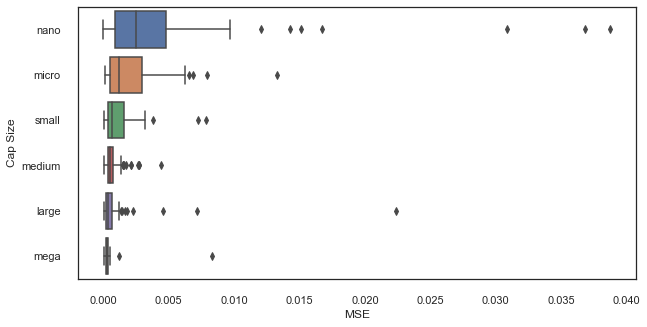

In [401]:
#test vs prediciton
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MSE']<0.05]
sns.set(rc = {'figure.figsize':(10,5)})
sns.set_theme(style="white")
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MSE'
            ,y = 'Cap_size'
            )
#plt.title('GARCH MSE',size=15)
plt.ylabel('Cap Size')
plt.show()

### MAPE

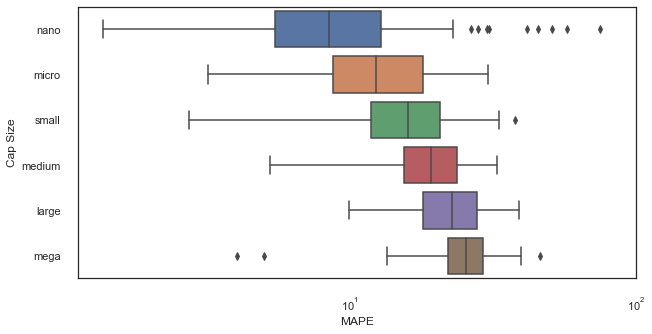

In [402]:
#test vs prediciton
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]
sns.set(rc = {'figure.figsize':(10,5)})
sns.set_theme(style="white")
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
plt.ylabel('Cap Size')
plt.xscale('log')
plt.xticks([10, 100])
plt.show()

<AxesSubplot:xlabel='MAPE', ylabel='Cap_size'>

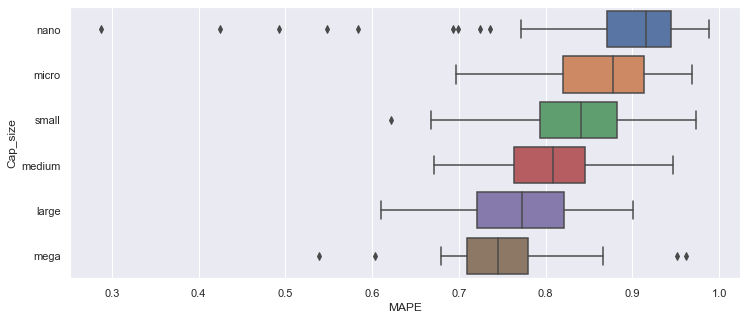

In [157]:
#abs(test) vs prediciton*100
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]
sns.set(rc = {'figure.figsize':(12,5)})
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
#plt.xscale('log')

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

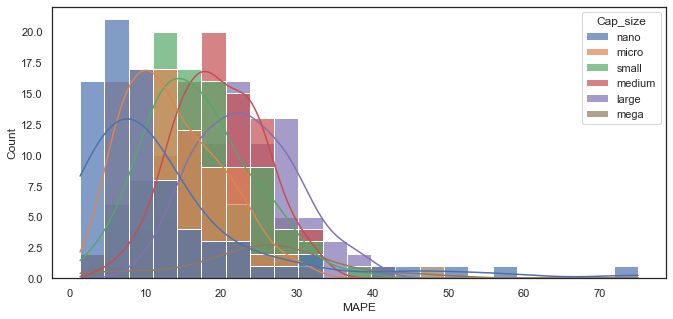

In [254]:
sns.histplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

In [255]:
metrics_df_concat.groupby('Cap_size').mean().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,12.597694,0.423630
micro,13.561959,0.002140
small,16.840061,0.001193
medium,19.603634,0.000774
large,23.236964,0.000912
mega,24.965282,0.000756


## Example: Google

In [339]:
#Example
a_file = open('processed_data/' + 'mega' + '_train.pkl', "rb")
train_data = pickle.load(a_file)
a_file = open('processed_data/' + 'mega' + '_test.pkl', "rb")
test_data = pickle.load(a_file)

pd.DataFrame(test_data['GOOGL'],columns=['date','return']).set_index(['date'])

,return
date,
2021-01-04,-0.008032
2021-01-05,0.009917
2021-01-06,-0.029431
2021-01-07,-0.013152
2021-01-08,0.023377
...,...
2021-12-03,-0.00809
2021-12-06,-0.028336
2021-12-07,-0.006207


In [340]:
stock_ticker = 'GOOGL'
cut_date = '2021-01-01'

train = pd.DataFrame(train_data[stock_ticker],columns=['date','return']).set_index(['date'])
test = pd.DataFrame(test_data[stock_ticker],columns=['date','return']).set_index(['date'])
data = pd.concat([train,test], axis=0).astype('float64')

basic_gm = arch_model(data.values, p=1, q=1, mean='constant', vol = 'ARCH', dist = 'normal')
start_loc = 0
end_loc = np.where(data.index >= test.index[0])[0].min()
forecasts = {} 
for i in range(1,len(test)+1):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
    temp = res.forecast(horizon=1).variance #mean or variance (residual variance)

    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
forecasts_df = pd.DataFrame(forecasts).T

.............................................................................................................................................................................................................................................

In [ ]:
#Non-rolling prediction
history = [x for x in train['return']]
not_rolling = []

# loop through every data point
for time_point in list(test.index):
    model = arch_model(history, p=1, q=1, mean='constant',
                       vol = 'GARCH', dist = 'normal')
    model_fit = model.fit(update_freq = 5, disp='off')
    output = model_fit.forecast(horizon=1).variance
    yhat = output.iloc[-1].values[0]
    not_rolling.append(yhat)
    history.append(yhat)

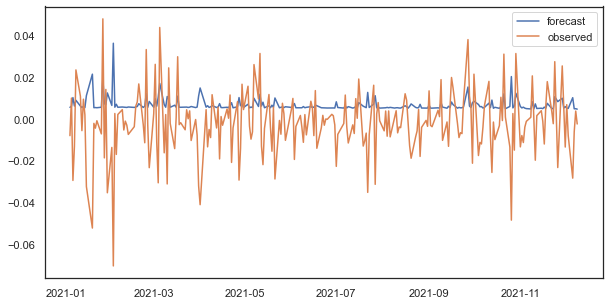

In [343]:
plt.figure(figsize=(10,5))
plt.plot(date_index[date_index >= cut_date].dropna(), forecasts_df['h.1']*20, label='forecast')
plt.plot(date_index[date_index >= cut_date].dropna(), test['return'], label='observed')
plt.legend()
plt.show()

In [344]:
#evaluation_metrics(test['return'], np.array(not_rolling)*20)
evaluation_metrics(test['return'], forecasts_df['h.1'])

{'MAPE': 29.01314875268716, 'MSE': 0.00024352617393492965}

In [347]:
arima = pd.read_csv('arima_googl.csv')
hmm = pd.read_csv('hmm_google.csv')

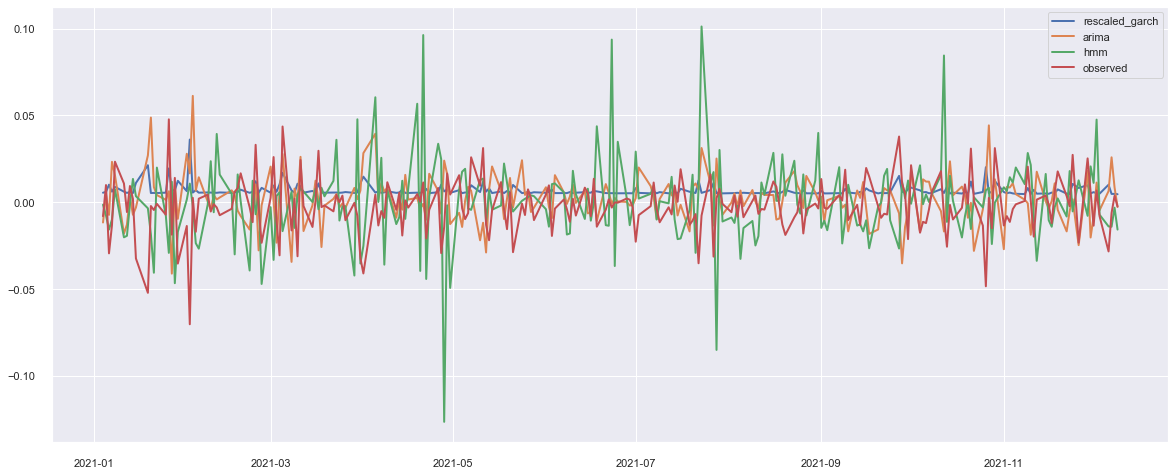

In [397]:
#plt.figure(figsize=(18,8))
sns.set(rc = {'figure.figsize':(20,8)})

plt.plot(date_index[date_index >= cut_date].dropna(), forecasts_df['h.1']*20, label='rescaled_garch',linewidth=2)
plt.plot(date_index[date_index >= cut_date].dropna(), arima['pred'], label='arima',linewidth=2)
plt.plot(date_index[date_index >= cut_date].dropna(), hmm['HMM'], label='hmm',linewidth=2)
plt.plot(date_index[date_index >= cut_date].dropna(), test['return'], label='observed',linewidth=2)

plt.legend()
plt.show()

In [367]:
print('garch:', evaluation_metrics(test['return'], forecasts_df['h.1']*20))
print('arima:', evaluation_metrics(test['return'], arima['pred']))
print('hmm:', evaluation_metrics(test['return'], hmm['HMM']))

garch: {'MAPE': 1.7904060533816395, 'MSE': 0.0003458987714206962}
arima: {'MAPE': 4.1490084020022575, 'MSE': 0.00041324791434930205}
hmm: {'MAPE': 4.301367136814982, 'MSE': 0.0008546895327394673}
